In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import os
import pickle
import librosa
import seaborn as sns

In [2]:
def spectrogram_to_audio(spectrogram, n_fft=2048, hop_length=None, win_length=None, window='hann'):
    """
    Convert a spectrogram back to audio using the inverse Short-Time Fourier Transform (ISTFT).
    
    Parameters:
    - spectrogram: 2D numpy array (magnitude spectrogram)
    - n_fft: FFT window size
    - hop_length: Number of samples between successive frames
    - win_length: Window length (defaults to n_fft)
    - window: Window type (e.g., 'hann', 'hamming')
    
    Returns:
    - audio: Reconstructed time-domain signal
    """
    if hop_length is None:
        hop_length = n_fft // 4
    if win_length is None:
        win_length = n_fft
    
    # Phase reconstruction (using random phases as initial guess)
    # For better results, you should preserve the original phase or use phase reconstruction algorithms
    phase = 2 * np.pi * np.random.rand(*spectrogram.shape)
    
    # Combine magnitude and phase to create complex spectrogram
    stft_matrix = spectrogram * np.exp(1j * phase)
    
    # Inverse STFT
    audio = librosa.istft(stft_matrix, hop_length=hop_length, win_length=win_length, window=window)
    
    return audio

In [3]:
def griffin_lim(spectrogram, n_iter=100, n_fft=2048, hop_length=None, win_length=None, window='hann'):
    """Griffin-Lim algorithm for phase reconstruction"""
    if hop_length is None:
        hop_length = n_fft // 4
    if win_length is None:
        win_length = n_fft
    
    # Initialize with random phase
    angles = 2 * np.pi * np.random.rand(*spectrogram.shape)
    stft = spectrogram * np.exp(1j * angles)
    
    for _ in range(n_iter):
        # Reconstruct audio
        audio = librosa.istft(stft, hop_length=hop_length, win_length=win_length, window=window)
        # Recompute STFT
        new_stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
        # Keep magnitude and update phase
        stft = spectrogram * np.exp(1j * np.angle(new_stft))
    
    return librosa.istft(stft, hop_length=hop_length, win_length=win_length, window=window)

In [4]:
def plot_spectrogram(audio_path, n_fft=2048, hop_length=512, win_length=1024):
    """
    Plot the waveform and spectrogram of an audio file.
    
    Parameters:
    - audio_path: Path to the audio file
    - n_fft: FFT window size
    - hop_length: Number of samples between successive frames
    - win_length: Window length
    """
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # Compute STFT (Short-Time Fourier Transform)
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    
    # Convert to dB scale for better visualization
    spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    
    # Create figure with subplots
    plt.figure(figsize=(12, 8))
    
    # Plot waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Plot spectrogram
    plt.subplot(2, 1, 2)
    librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length, 
                            x_axis='time', y_axis='log', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    
    plt.tight_layout()
    plt.show()


In [5]:
def create_spectograms(folder_path):
    specs = []
    for filename in os.listdir(folder_path):
        # Check if the file is a .txt file
        if filename.endswith('.wav'):
            # Construct full file path
            audio_file = os.path.join(folder_path, filename)
            y, sr = librosa.load(audio_file, sr=26200)

            # Parameters for STFT
            n_fft = 1024
            hop_length = 256
            win_length = 1024

            # Compute the STFT (spectrogram)
            stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
            spectrogram = np.abs(stft)[1:]
            if spectrogram.shape != (512,512): continue
            specs.append(spectrogram)
    return np.array(specs)
            

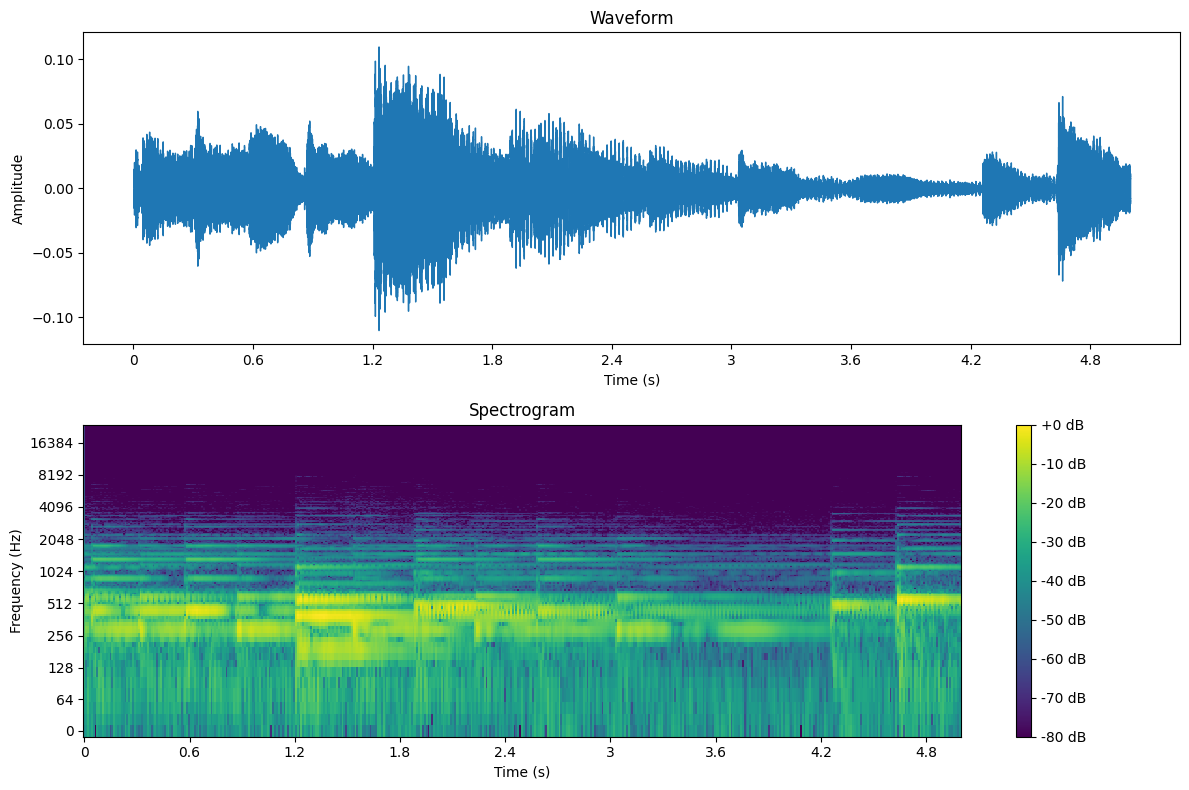

In [6]:
audio_file = "piano/samples/segment_002.wav"  
plot_spectrogram(audio_file)

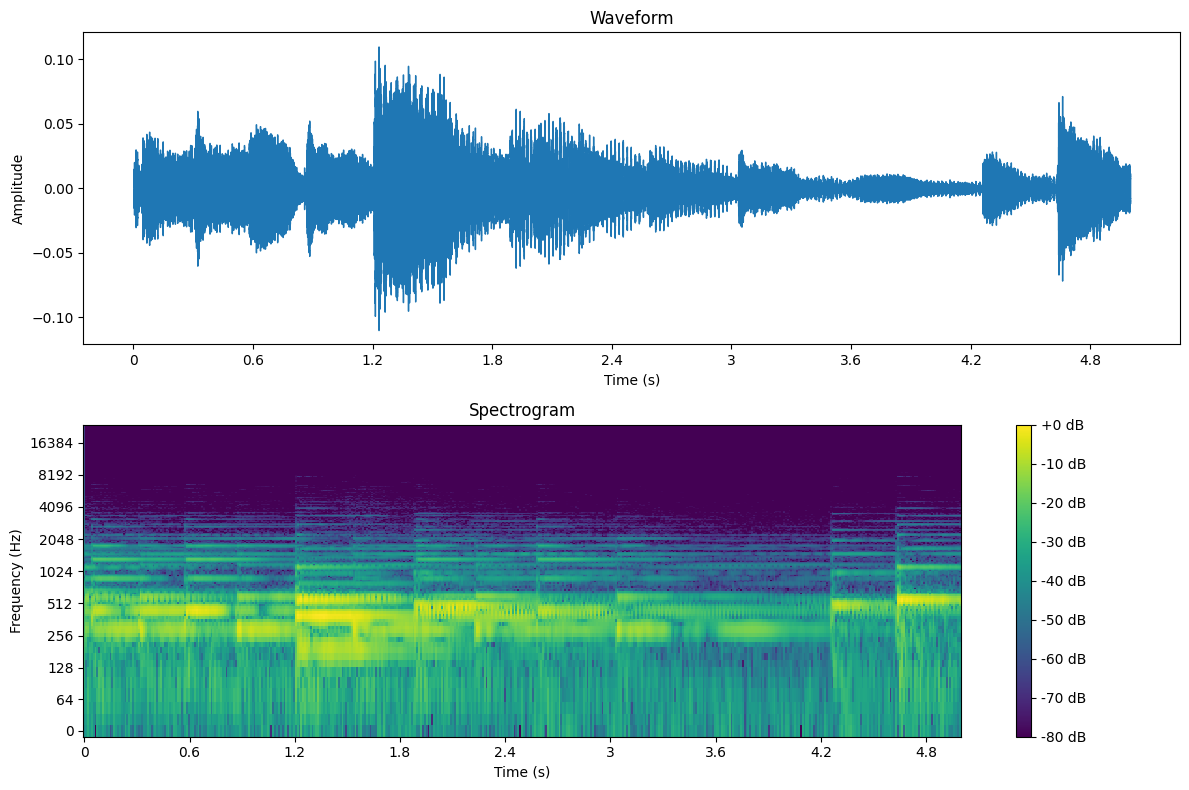

In [7]:
audio_file = "piano/samples/segment_002.wav"  
plot_spectrogram(audio_file)

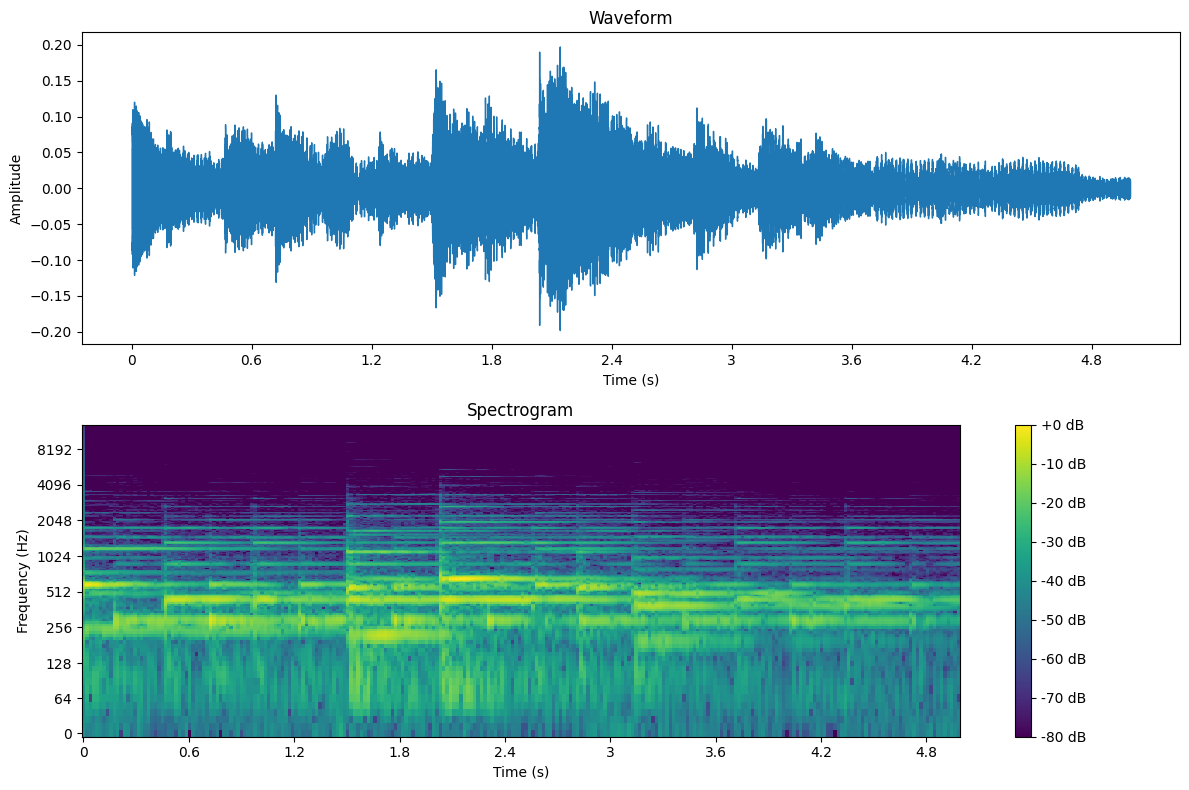

In [8]:
audio_file = "reconstructed_audio.wav"  
plot_spectrogram(audio_file)

Reconstructed audio saved to reconstructed_audio.wav


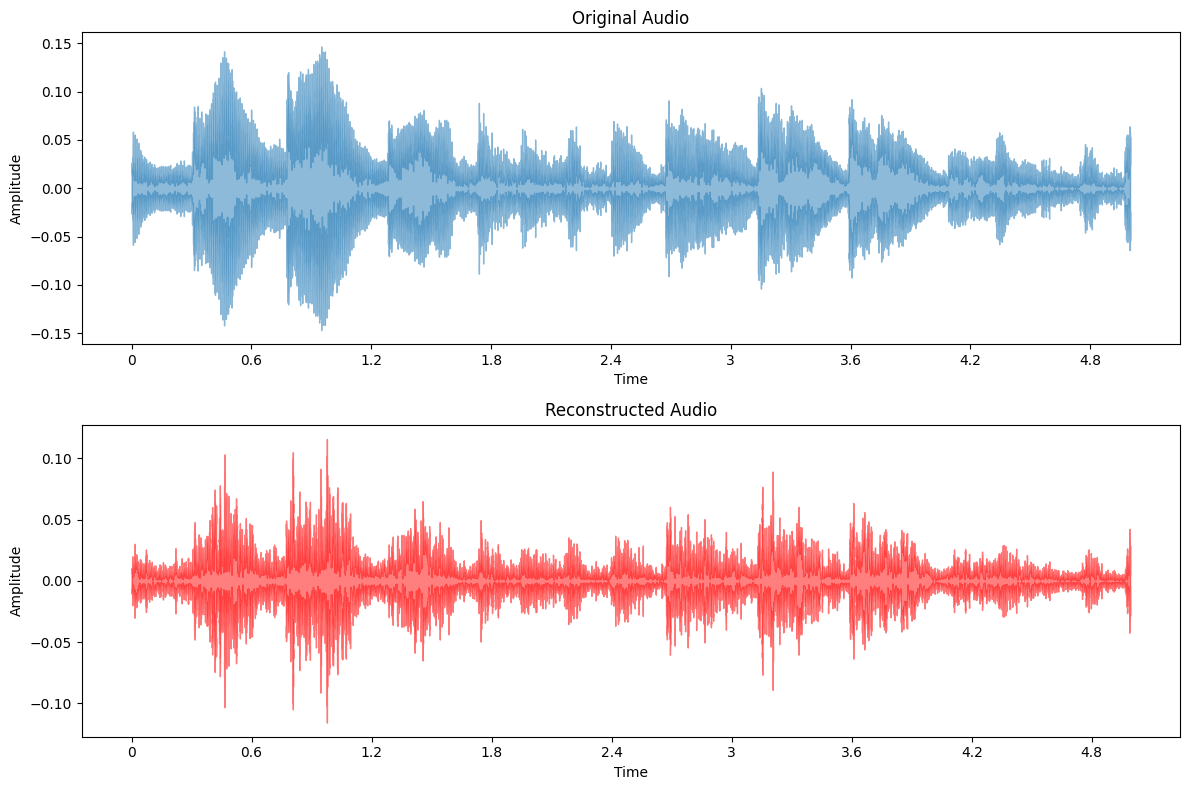

In [12]:
 # Load an example audio file
audio_file = "maestro\samples\MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1_006.wav"  
y, sr = librosa.load(audio_file, sr=None)

# Parameters for STFT
n_fft = 2048
hop_length = 512
win_length = 1024

# Compute the STFT (spectrogram)
stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
spectrogram = np.abs(stft)

# Convert spectrogram back to audio
reconstructed_audio = spectrogram_to_audio(
    spectrogram, 
    n_fft=n_fft, 
    hop_length=hop_length, 
    win_length=win_length
)

# Save the reconstructed audio
output_file = "reconstructed_audio.wav"
sf.write(output_file, reconstructed_audio, sr)
print(f"Reconstructed audio saved to {output_file}")

# Plot the original and reconstructed signals
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.title("Original Audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
librosa.display.waveshow(reconstructed_audio, sr=sr, color='r', alpha=0.5)
plt.title("Reconstructed Audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


Reconstructed audio saved to reconstructed_audio.wav


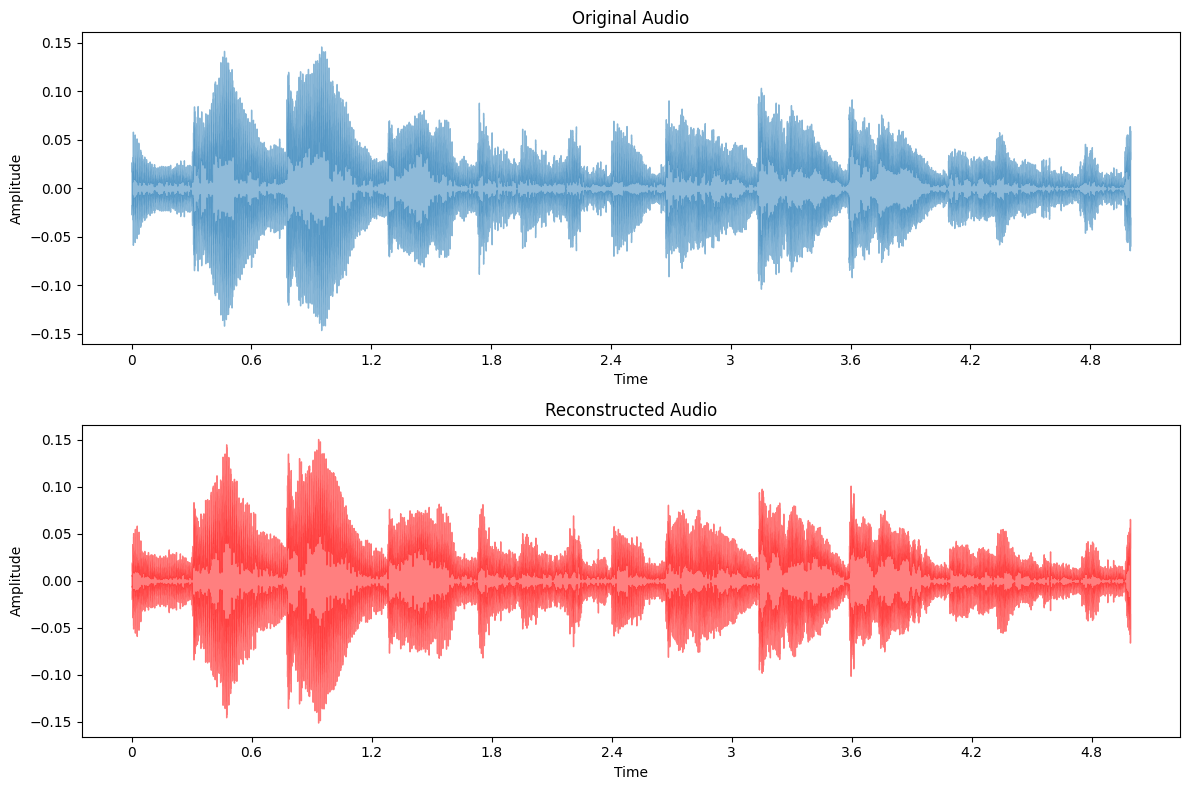

In [13]:
 # Load an example audio file
audio_file = "maestro\samples\MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1_006.wav"  
y, sr = librosa.load(audio_file, sr=26200) # 26200:512, 13100:256

# Parameters for STFT
n_fft = 1024
hop_length = 256
win_length = 1024

# Compute the STFT (spectrogram)
stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
spectrogram = np.abs(stft)

# Convert spectrogram back to audio
reconstructed_audio = griffin_lim(
    spectrogram, 
    n_fft=n_fft, 
    hop_length=hop_length, 
    win_length=win_length
)

# Save the reconstructed audio
output_file = "reconstructed_audio.wav"
sf.write(output_file, reconstructed_audio, sr)
print(f"Reconstructed audio saved to {output_file}")

# Plot the original and reconstructed signals
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.title("Original Audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
librosa.display.waveshow(reconstructed_audio, sr=sr, color='r', alpha=0.5)
plt.title("Reconstructed Audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [14]:
spectrogram.shape

(513, 512)

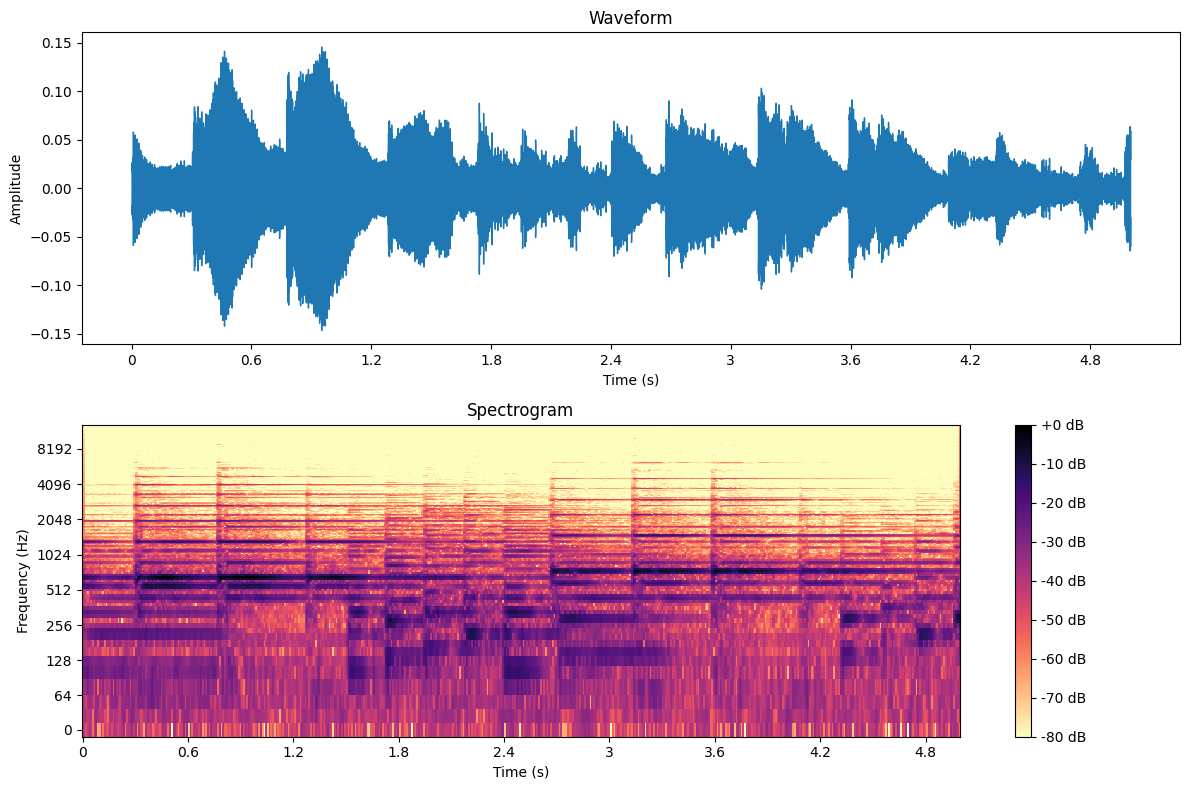

In [15]:
# Convert to dB scale for better visualization
spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

# Create figure with subplots
plt.figure(figsize=(12, 8))

# Plot waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot spectrogram
plt.subplot(2, 1, 2)
librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length, 
                        x_axis='time', y_axis='log', cmap='magma_r')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


In [16]:
spectrogram.shape

(513, 512)

In [17]:
specs = create_spectograms('piano/samples')

In [18]:
from torchaudio import transforms as AT
from torchvision import transforms as IT
import torch
import random
from diffusers import DiffusionPipeline
from IPython.display import Audio



c:\Users\mharu\miniconda3\envs\aud\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-instrumental-hiphop-256").to(device)


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\mharu\.cache\huggingface\hub\models--teticio--audio-diffusion-instrumental-hiphop-256\snapshots\a63b0c7e794925f74f021d356c13bce47cb69264\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\mharu\.cache\huggingface\hub\models--teticio--audio-diffusion-instrumental-hiphop-256\snapshots\a63b0c7e794925f74f021d356c13bce47cb69264\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]


In [20]:
resampler = AT.Resample(22100, 22100, dtype=torch.float32)
to_t = IT.ToTensor()
def to_image(audio_array):
  audio_tensor = torch.tensor(audio_array).to(torch.float32)
  audio_tensor = resampler(audio_tensor)
  pipe.mel.load_audio(raw_audio=np.array(audio_tensor))
  num_slices = pipe.mel.get_number_of_slices()
  slice_idx = random.randint(0, num_slices-1) # Pic a random slice each time (excluding the last short slice)
  im = pipe.mel.audio_slice_to_image(slice_idx)
  return im

In [21]:
img = to_image(y)

C:\Users\mharu\AppData\Local\Temp\ipykernel_18864\2737989212.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  pipe.mel.load_audio(raw_audio=np.array(audio_tensor))


In [22]:
type(img)

PIL.Image.Image

In [23]:
a = pipe.mel.image_to_audio(img)


In [24]:
display(Audio(a, rate=22100)) # 2x speed

In [25]:
a.max()

np.float32(0.013468272)

In [26]:
folder_path = "maestro\samples"
for filename in os.listdir(folder_path):
    # Check if the file is a .txt file
    if filename.endswith('.wav'):
        # Construct full file path
        audio_file = os.path.join(folder_path, filename)
        y, sr = librosa.load(audio_file, sr=26200)
        img = to_image(y)
        img.save(f"maestro/images/{filename}.jpg")

C:\Users\mharu\AppData\Local\Temp\ipykernel_18864\2737989212.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  pipe.mel.load_audio(raw_audio=np.array(audio_tensor))
